In [65]:
import scanpy as sc
import numpy as np
import scipy as sp
from scipy.stats import spearmanr, pearsonr, wilcoxon

import pandas as pd

In [66]:
# Importing plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from matplotlib import cm

sns.set_style('ticks', {'font.family': 'FreeSans'})

In [67]:
# Scanpy settings
sc.settings.verbosity = 3            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

#celltype = 'all'
master_dir = '../'

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.4 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [68]:
# Get the dictionary associating pathway names with metabolic classifications
classifications = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg-KEGGclassified.gmt', 
                              header=None, sep='\t')
classifications.index = classifications[0]
classifications = classifications.drop(columns=[0])
classifications.columns = ['classification']
classifications = classifications.to_dict()['classification']

In [69]:
adata_metab = sc.read_h5ad(master_dir + 'output/disease_comparisons/disease-comparison-metab-Monocyte.h5ad')
adata = sc.read_h5ad(master_dir + 'data/PBMC_processed/disease_comparisons/normalized_MAGIC_ALL_MONO.h5ad')
adata_metab

AnnData object with n_obs × n_vars = 196177 × 1102
    obs: 'Age_at_baseline', 'Blood_draw_time', 'CellID', 'Days_since_onset_of_symptoms', 'ICU_status', 'IL6i_between_draws', 'MajorCluster', 'Sex', 'TimePoint', 'UMAP1', 'UMAP2', 'WHO_scale', 'barcode', 'batch', 'batch_info', 'biosample_id', 'cancer', 'cell_groups', 'cell_state', 'cell_type', 'cell_type__ontology_label', 'disease', 'disease__ontology_label', 'donor_id', 'end_bias', 'enrichment__cell_type', 'enrichment__cell_type__ontology_label', 'enrichment__facs_markers', 'enrichment_method', 'geographical_region', 'geographical_region__ontology_label', 'is_living', 'library_id', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'nGene', 'nUMI', 'n_counts', 'n_genes', 'no_IL6i', 'organ', 'organ__ontology_label', 'organism_age', 'organism_age__unit', 'organism_age__unit_label', 'paired_ends', 'patient', 'percent_hsp', 'percent_mito', 'pheno', 'read_length', 'sample_type', 'sequencing_instrument_manufactur

In [70]:
# Loading in metabolics-relevant pathways from KEGG (based on Xiao et al. Nat Commun 2019)
#metab_pathway_list = pd.read_csv(master_dir + 'data/MSigDB/KEGG_metab_pathway_list_Xiao2019-JLmod200620.txt', 
#                                 sep='\t', header=None)
#metab_pathway_list = np.array(metab_pathway_list.iloc[:, 0])

# Genes in each KEGG pathway
metab_genes = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg.gmt', 
                          sep='\t', header=None)
metab_genes.index = metab_genes.iloc[:, 0]
metab_genes = metab_genes.drop([0], axis=1)
# Drop the following pathways because none of the genes are found in the preprocessed adata
metab_genes = metab_genes.drop(index=['C5-Branched dibasic acid metabolism',
                                     'Lysine biosynthesis', 
                                     'D-Arginine and D-ornithine metabolism',
                                     'Polyketide sugar unit biosynthesis', 
                                     'Biosynthesis of vancomycin group antibiotics', 
                                     'Penicillin and cephalosporin biosynthesis'])

metab_pathway_list = metab_genes.index
metab_genes.head()

,1,2,3,4,5,6,7,8,9,10,...,124,125,126,127,128,129,130,131,132,133
0,,,,,,,,,,,,,,,,,,,,,
Glycolysis / Gluconeogenesis,LDHC,HK3,LDHB,PFKP,ALDOA,ALDOB,ADH6,GAPDHS,DLAT,PGM1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Citrate cycle (TCA cycle),DLST,ACO1,CS,IDH3B,ACLY,SUCLG2,DLAT,IDH3A,SUCLA2,PDHB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pentose phosphate pathway,PFKP,ALDOA,RPIA,ALDOB,H6PD,RPE,RPEL1,PRPS1L1,PFKM,RBKS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pentose and glucuronate interconversions,UGT2B4,UGT2A1,XYLB,CRYL1,UGT2B17,UGT1A3,UGDH,UGT1A4,UGT1A8,UGP2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fructose and mannose metabolism,HK3,PFKFB3,PFKP,FCSK,ALDOA,ALDOB,GFUS,TPI1,PMM2,SORD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# Convert the metabolic pathways dataframe into a dictionary for GSEA
metab_genes_dict = metab_genes.transpose().to_dict(orient='series')
for element in metab_genes_dict:
    # Only include the genes that are also found in the single cell sequencing
    metab_genes_dict[element] = list(set(metab_genes_dict[element]).intersection(set(adata.var_names)))


In [72]:
# Also get a flat array of metabolism-related genes
metab_gene_list = []
for geneset in metab_genes_dict.values():
    for gene in geneset:
        metab_gene_list.append(gene)
metab_gene_list = np.array(metab_gene_list)
len(metab_gene_list)

1879

# Pathway activity analysis 
Modeled after Xiao et al. <i>Nat Commun</i> (2019) Fig. 2

For the i-th metabolic gene, the <u>mean expression level</u> across cells of the j-th cell type is

$E_{i,j} = \frac{\sum_{k=1}^{n_j} g_{i,k}}{n_j}, i \in 1 ... M, j \in 1 ... N $

in which $n_j$ is the number of cells in the j-th cell type, $g_{i,k}$ is the expression level of the i-th gene in the k-th cell in this cell type, M is the number of metabolic genes, and N is the number of cell types.

<u>Relative expression level</u> of gene i in cell type j is

$r_{i,j} = \frac{E_{i,j}}{1/N \sum_j^N E_{i,j}}$

Exclude genes with low expression level or high dropout rate:

Exclude outliers in each pathway defined by genes with relative expression levels >3 x 75th percentile expression or <1/3 x 25th percentile

<u>Pathway activity score for the t-th pathway and the j-th cell type is the weighted average of $r_{i,j}$ over all genes included in this pathway:</u>

$p_{t,j} = \frac{\sum_{i=1}^{m_t} w_i \times r_{i,j}}{\sum_{i=1}^{m_t} w_i}$

where $m_t$ is the number of genes in the pathway t, $w_i$ is the weighting factor equal to the reciprocal of the number of pathways that include the i-th gene.

In [73]:
pathways = [list(genes) for genes in list(metab_genes_dict.values())]

# wi is the reciprocal of the number of pathways that include the ith gene,
# summarized in array w
w = [[pathway.count(gene) / list(metab_gene_list).count(gene) for gene 
      in adata_metab.var_names.values] for pathway in pathways]

In [74]:
# Here, cell type is defined as individual clusters ('louvain')
# within a given group of immune cells (B cells, T cells, etc.)
# Clusters calculated from all genes rather than just metabolic genes
# in order to associate the metabolic gene set enrichment with the non-metabolic analyses
def pathway_activity(data, data_metab, cluster_label, print_labels=False, nanval=0, exclude_clusters=[]):
    cluster_ids = list(data.obs[cluster_label].unique())
    cluster_ids.sort()
    
    for cluster_id in exclude_clusters:
        cluster_ids.remove(cluster_id)
        
    mel = np.zeros([len(cluster_ids), len(data_metab.X[0])])
    for i, cluster_id in enumerate(cluster_ids):
        if print_labels:
            print(cluster_id)
        cluster = data_metab[data.obs[cluster_label]==cluster_id]
        g = cluster.X # Matrix of gene expression of ith gene in the kth cell of this cluster (cell type)
        n = len(cluster) # Number of cells in the cluster (cell type)
        # Calculate mean expression level
        mel[i] = np.sum(g, axis=0) / n # Sum gene expressions per gene across all cells in this cluster (cell type),
            # divided by number of cells in the cluster (cell type)        

    # Remove genes that are 0 in any cluster to avoid extreme ratio value
    mel = np.array(mel)
    m = min(mel[mel > 0])
    mel[mel==0] = m
            
    # Calculate relative expression level of each gene
    rel = mel / (np.sum(mel, axis=0) / len(mel))

    # Filtering
    lowExpr, highExpr = np.percentile(rel, [25, 75], axis=None) 
    
    tooHigh = (rel > 3 * highExpr) * rel
    tooLow = (rel < lowExpr / 3) * rel
    
    rel -= tooHigh
    rel -= tooLow
    rel = np.nan_to_num(rel, nan=nanval)
    
    # Calculate the pathway activity score
    # Pathway activity matrix
    # Each row is a pathway, each column is a cluster
    p = np.array([np.sum(w * rel[j], axis=1) / np.sum(w, axis=1) for j in range(len(rel))]).transpose()
    
    # Remove nan values
    p = np.nan_to_num(p, nan=1)
    
    return p

In [75]:
adata.obs['disease_state'].unique()

['Control', 'COVID-19', 'Hyperacute HIV', 'Bacterial Sepsis', 'Kidney TIL']
Categories (5, object): ['Control', 'COVID-19', 'Hyperacute HIV', 'Bacterial Sepsis', 'Kidney TIL']

In [76]:
adata.obs['cell_type'].unique()

['Non-Classical', 'Classical - Dysfunctional', 'Classical - Rest', 'Not Monocyte cDC/T/B', 'Non-Confident Monocyte']
Categories (5, object): ['Non-Classical', 'Classical - Dysfunctional', 'Classical - Rest', 'Not Monocyte cDC/T/B', 'Non-Confident Monocyte']

In [77]:
adata.obs['cell_type_per_dz'] = adata.obs['cell_type'].astype(str) + ' of ' + adata.obs['disease_state'].astype(str)
adata_metab.obs['cell_type_per_dz'] = adata_metab.obs['cell_type'].astype(str) + \
                ' of ' + adata_metab.obs['disease_state'].astype(str)

In [78]:
adata.obs['cell_type_per_dz'].unique()

array(['Non-Classical of Control', 'Classical - Dysfunctional of Control',
       'Classical - Rest of Control', 'Not Monocyte cDC/T/B of Control',
       'Non-Confident Monocyte of Control', 'Non-Classical of COVID-19',
       'Classical - Rest of COVID-19',
       'Non-Confident Monocyte of COVID-19',
       'Not Monocyte cDC/T/B of COVID-19',
       'Classical - Dysfunctional of COVID-19',
       'Non-Classical of Hyperacute HIV',
       'Classical - Rest of Hyperacute HIV',
       'Classical - Dysfunctional of Hyperacute HIV',
       'Classical - Rest of Bacterial Sepsis',
       'Classical - Dysfunctional of Bacterial Sepsis',
       'Non-Classical of Bacterial Sepsis',
       'Non-Confident Monocyte of Bacterial Sepsis',
       'Not Monocyte cDC/T/B of Bacterial Sepsis',
       'Non-Classical of Kidney TIL', 'Classical - Rest of Kidney TIL',
       'Classical - Dysfunctional of Kidney TIL',
       'Not Monocyte cDC/T/B of Kidney TIL'], dtype=object)

<AxesSubplot:>

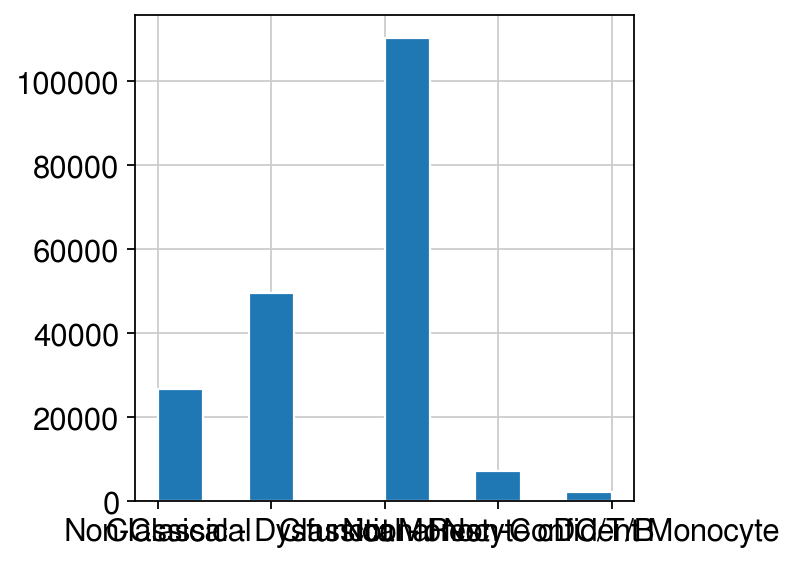

In [79]:
adata.obs['cell_type'].hist()

<AxesSubplot:>

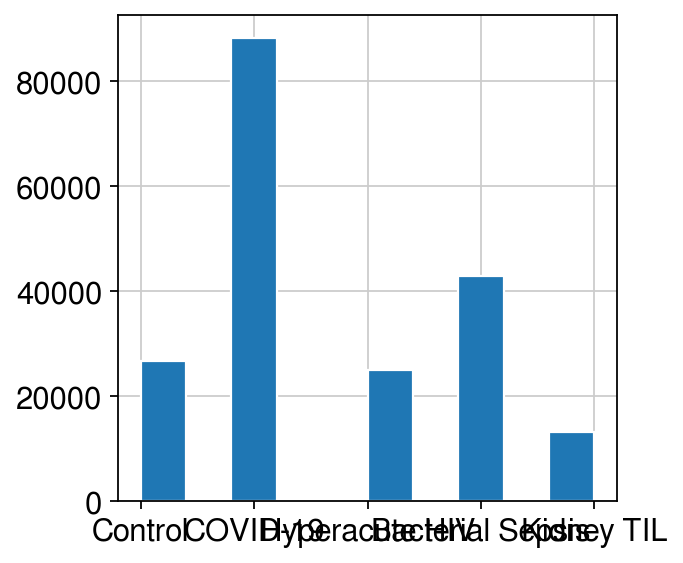

In [80]:
adata.obs['disease_state'].hist()

## Pathway activity analysis between cell types

In [18]:
p = pathway_activity(adata, adata_metab, 'cell_type_per_dz', print_labels=True,
                    exclude_clusters=['Non-Classical of Control', 'Classical - Dysfunctional of Control',
                   'Classical - Rest of Control', 'Not Monocyte cDC/T/B of Control',
                   'Non-Confident Monocyte of Control', 
                   'Non-Confident Monocyte of COVID-19',
                   'Not Monocyte cDC/T/B of COVID-19',
                   'Non-Confident Monocyte of Bacterial Sepsis',
                   'Not Monocyte cDC/T/B of Bacterial Sepsis',
                   'Not Monocyte cDC/T/B of Kidney TIL'])

Classical - Dysfunctional of Bacterial Sepsis
Classical - Dysfunctional of COVID-19
Classical - Dysfunctional of Hyperacute HIV
Classical - Dysfunctional of Kidney TIL
Classical - Rest of Bacterial Sepsis
Classical - Rest of COVID-19
Classical - Rest of Hyperacute HIV
Classical - Rest of Kidney TIL
Non-Classical of Bacterial Sepsis
Non-Classical of COVID-19
Non-Classical of Hyperacute HIV
Non-Classical of Kidney TIL


Calculate <u>statistical significance</u>: random permutation test
1. Randomly shuffle cell type labels 5,000 times to simulate null distribution of pathway activity scores
2. Compare to the pathway activity scores in the original, non-shuffled dataset
3. p-value = fraction of random pathway activity scores 
    - $> p_{t,j}$ if $p_{t,j} > 1$, meaning that pathway activity is significantly higher 
    - $< p_{t,j}$ if $p_{t,j} < 1$, meaning that pathway activity is significantly lower

In [19]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 1000x
n = 1000
compares = np.zeros((len(p), len(p[0])))

# Declare relevant variables before for loop to prevent memory leaks
obs_name = 'cell_type_per_dz'

# Shuffle cell cluster labels 1000x
data = adata[~adata.obs[obs_name].isin(['Non-Classical of Control', 'Classical - Dysfunctional of Control',
                   'Classical - Rest of Control', 'Not Monocyte cDC/T/B of Control',
                   'Non-Confident Monocyte of Control', 
                   'Non-Confident Monocyte of COVID-19',
                   'Not Monocyte cDC/T/B of COVID-19',
                   'Non-Confident Monocyte of Bacterial Sepsis',
                   'Not Monocyte cDC/T/B of Bacterial Sepsis',
                   'Not Monocyte cDC/T/B of Kidney TIL'])]
data_metab = adata_metab[data.obs[obs_name].index]

data.obs[obs_name + '_shuffle'] = pd.Series()
data_metab.obs[obs_name + '_shuffle'] = pd.Series()
clusters_shuffled = np.zeros(len(data.obs))
p_shuffle = np.zeros([len(w), len(data.obs[obs_name].unique())])

for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(data.obs[obs_name])
    data.obs[obs_name + '_shuffle'] = clusters_shuffled
    data_metab.obs[obs_name + '_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(data, data_metab, obs_name + '_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

<ipython-input-19-43f2a1587c4c>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data.obs[obs_name + '_shuffle'] = pd.Series()
Trying to set attribute `.obs` of view, copying.
<ipython-input-19-43f2a1587c4c>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data_metab.obs[obs_name + '_shuffle'] = pd.Series()
Trying to set attribute `.obs` of view, copying.


0
100
200
300
400
500
600
700
800
900


In [20]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

In [21]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/disease_comparisons/' + obs_name + '-metab-pathway_activity-Monocyte.tabular', 
                       sep='\t', header=None, index=None)
# Read saved pathway activity scores
df_p = pd.read_csv(master_dir + 'output/disease_comparisons/' + obs_name + 
                   '-metab-pathway_activity-Monocyte.tabular', 
                   sep='\t', header=None)
df_p.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.715578,0.954506,0.952017,1.268202,0.792963,0.749877,0.767557,1.184712,1.173937,1.048351,0.889071,1.414129
1,0.527540,0.943705,0.943336,1.264963,0.613996,0.694427,0.676245,1.395658,1.042851,1.153420,0.868214,1.875644
2,0.558491,0.909941,0.809552,1.383203,0.629349,0.695237,0.608112,1.183495,1.055159,1.094181,0.727257,1.866015
3,0.513398,0.790381,0.814590,1.541281,0.609059,0.665480,0.594382,1.469016,1.047276,1.197649,0.625967,2.102737
4,0.468451,0.886482,0.846185,1.342080,0.599709,0.700381,0.649526,1.647653,0.950265,1.178448,0.781651,1.807471


<ipython-input-23-f50a1807b05a>:15: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0), row_cluster=False, col_cluster=False, figsize=(4, 10))


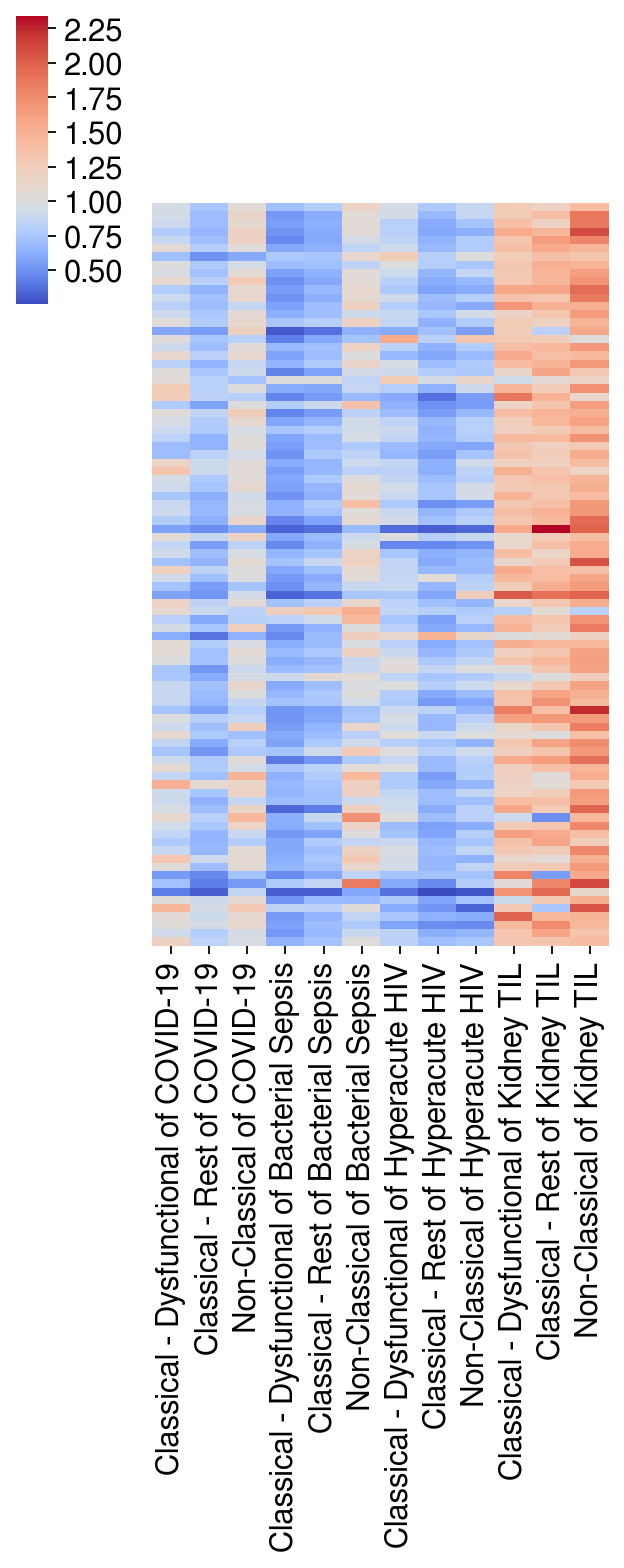

In [23]:
fig = sns.clustermap(df_p.loc[:, [1, 5, 9, 0, 4, 8, 2, 6, 10, 3, 7, 11]], cmap='coolwarm', 
                     xticklabels=pd.Series(['Classical - Dysfunctional of Bacterial Sepsis',
                        'Classical - Dysfunctional of COVID-19',
                        'Classical - Dysfunctional of Hyperacute HIV',
                        'Classical - Dysfunctional of Kidney TIL',
                        'Classical - Rest of Bacterial Sepsis',
                        'Classical - Rest of COVID-19',
                        'Classical - Rest of Hyperacute HIV',
                        'Classical - Rest of Kidney TIL',
                        'Non-Classical of Bacterial Sepsis',
                        'Non-Classical of COVID-19',
                        'Non-Classical of Hyperacute HIV',
                        'Non-Classical of Kidney TIL']).iloc[[1, 5, 9, 0, 4, 8, 2, 6, 10, 3, 7, 11]], 
                     yticklabels=[], #yticklabels=metab_genes.index, 
                     norm=DivergingNorm(1.0), row_cluster=False, col_cluster=False, figsize=(4, 10))
plt.savefig(master_dir + 'output/disease_comparisons/metab-pathways-per-dz_heatmap-Monocyte.pdf')

### Same as above, but excluding cancer

In [81]:
p = pathway_activity(adata, adata_metab, 'cell_type_per_dz', print_labels=True,
                    exclude_clusters=['Non-Classical of Control', 'Classical - Dysfunctional of Control',
                   'Classical - Rest of Control', 'Not Monocyte cDC/T/B of Control',
                   'Non-Confident Monocyte of Control', 
                   'Non-Confident Monocyte of COVID-19',
                   'Not Monocyte cDC/T/B of COVID-19',
                   'Non-Confident Monocyte of Bacterial Sepsis',
                   'Not Monocyte cDC/T/B of Bacterial Sepsis',
                   'Not Monocyte cDC/T/B of Kidney TIL',
                   'Classical - Dysfunctional of Kidney TIL',
                   'Classical - Rest of Kidney TIL',
                   'Non-Classical of Kidney TIL'])

Classical - Dysfunctional of Bacterial Sepsis
Classical - Dysfunctional of COVID-19
Classical - Dysfunctional of Hyperacute HIV
Classical - Rest of Bacterial Sepsis
Classical - Rest of COVID-19
Classical - Rest of Hyperacute HIV
Non-Classical of Bacterial Sepsis
Non-Classical of COVID-19
Non-Classical of Hyperacute HIV


In [82]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 1000
compares = np.zeros((len(p), len(p[0])))

# Declare relevant variables before for loop to prevent memory leaks
obs_name = 'cell_type_per_dz'

# Shuffle cell cluster labels 5000x
data = adata[~adata.obs[obs_name].isin(['Non-Classical of Control', 'Classical - Dysfunctional of Control',
                   'Classical - Rest of Control', 'Not Monocyte cDC/T/B of Control',
                   'Non-Confident Monocyte of Control', 
                   'Non-Confident Monocyte of COVID-19',
                   'Not Monocyte cDC/T/B of COVID-19',
                   'Non-Confident Monocyte of Bacterial Sepsis',
                   'Not Monocyte cDC/T/B of Bacterial Sepsis',
                   'Not Monocyte cDC/T/B of Kidney TIL',
                   'Classical - Dysfunctional of Kidney TIL',
                   'Classical - Rest of Kidney TIL',
                   'Non-Classical of Kidney TIL'])]
data_metab = adata_metab[data.obs[obs_name].index]

data.obs[obs_name + '_shuffle'] = pd.Series()
data_metab.obs[obs_name + '_shuffle'] = pd.Series()
clusters_shuffled = np.zeros(len(data.obs))
p_shuffle = np.zeros([len(w), len(data.obs[obs_name].unique())])

for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(data.obs[obs_name])
    data.obs[obs_name + '_shuffle'] = clusters_shuffled
    data_metab.obs[obs_name + '_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(data, data_metab, obs_name + '_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

<ipython-input-82-7616e346dc26>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data.obs[obs_name + '_shuffle'] = pd.Series()
Trying to set attribute `.obs` of view, copying.
<ipython-input-82-7616e346dc26>:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data_metab.obs[obs_name + '_shuffle'] = pd.Series()
Trying to set attribute `.obs` of view, copying.


0
100
200
300
400
500
600
700
800
900


In [85]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

In [86]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/disease_comparisons/' + obs_name + 
            '-metab-pathway_activity-no_cancer-Monocyte.tabular', 
                       sep='\t', header=None, index=None)
# Read saved pathway activity scores
df_p = pd.read_csv(master_dir + 'output/disease_comparisons/' + obs_name + 
                   '-metab-pathway_activity-no_cancer-Monocyte.tabular', 
                   sep='\t', header=None)
df_p.head()

,0,1,2,3,4,5,6,7,8
0,0.786398,1.083053,1.065657,0.875380,0.850510,0.853187,1.298612,1.198494,1.000000
1,0.627825,1.139730,1.131132,0.733573,0.843240,0.813692,1.254133,1.415159,1.041514
2,0.663154,1.188666,1.000000,0.761341,0.909093,0.805012,1.292851,1.408988,0.915702
3,0.655276,1.016782,1.033598,0.794837,0.890762,0.767311,1.386576,1.651800,0.803059
4,0.609434,1.123107,1.072350,0.732637,0.902098,0.838365,1.187638,1.519535,1.000000


<ipython-input-87-99f82c551d78>:13: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0), row_cluster=False, col_cluster=False, figsize=(4, 10))


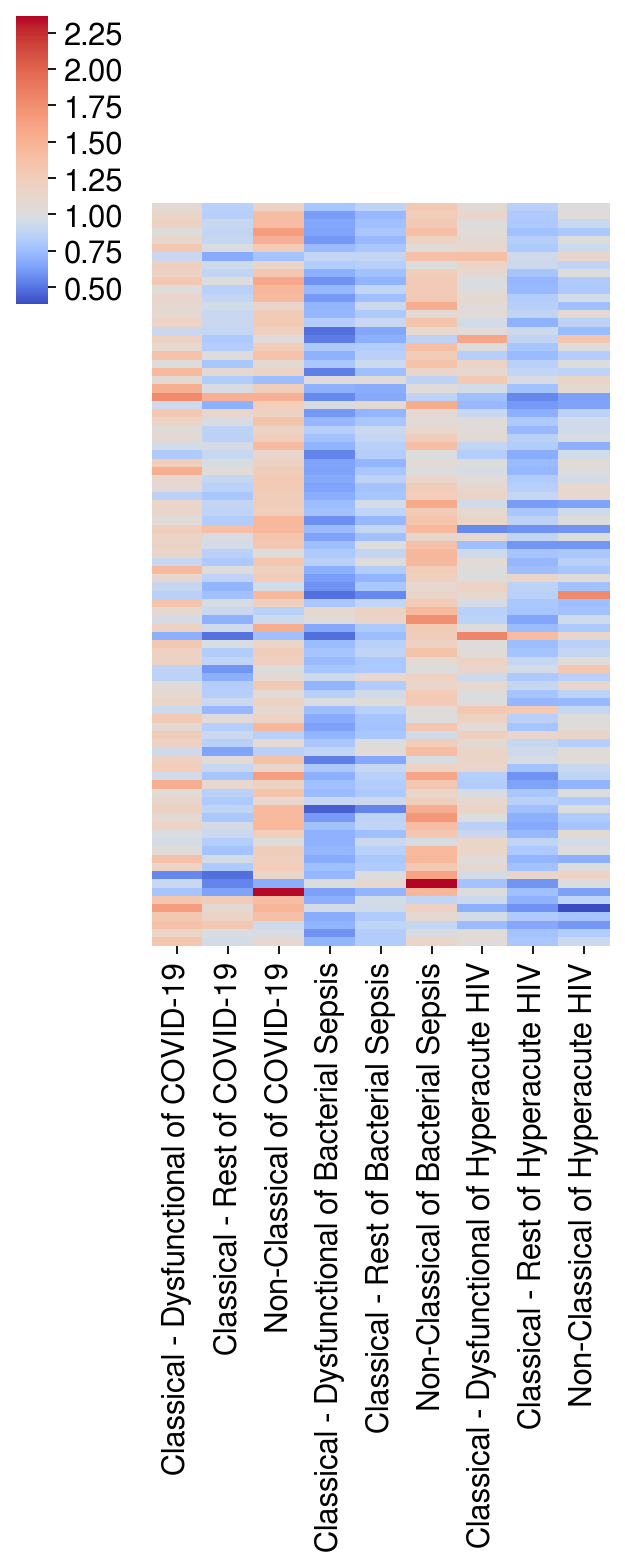

In [87]:
fig = sns.clustermap(df_p.loc[:, [1, 4, 7, 0, 3, 6, 2, 5, 8]], cmap='coolwarm', 
                     xticklabels=pd.Series(['Classical - Dysfunctional of Bacterial Sepsis',
                        'Classical - Dysfunctional of COVID-19',
                        'Classical - Dysfunctional of Hyperacute HIV',
                        'Classical - Rest of Bacterial Sepsis',
                        'Classical - Rest of COVID-19',
                        'Classical - Rest of Hyperacute HIV',
                        'Non-Classical of Bacterial Sepsis',
                        'Non-Classical of COVID-19',
                        'Non-Classical of Hyperacute HIV']).iloc[[1, 4, 7, 0, 3, 6, 2, 5, 8]], 
                     
                     yticklabels=[], #yticklabels=metab_genes.index, 
                     norm=DivergingNorm(1.0), row_cluster=False, col_cluster=False, figsize=(4, 10))
plt.savefig(master_dir + 'output/disease_comparisons/metab-pathways-per-dz_heatmap-no_cancer-Monocyte.pdf')

## Venn diagrams of differential metabolic gene expression or metabolic pathway activities
### Gene expression-based


In [25]:
from matplotlib_venn import venn3, venn3_circles

In [52]:
# Get list of differentially expressed metabolic pathways and genes among the PE groups in each disease
# PE groups only
data = adata[adata.obs[obs_name].isin(['Classical - Dysfunctional of Bacterial Sepsis',
                        'Classical - Dysfunctional of COVID-19',
                        'Classical - Dysfunctional of Hyperacute HIV',
                        'Classical - Dysfunctional of Kidney TIL',
                        'Classical - Rest of Bacterial Sepsis',
                        'Classical - Rest of COVID-19',
                        'Classical - Rest of Hyperacute HIV',
                        'Classical - Rest of Kidney TIL',
                        'Non-Classical of Bacterial Sepsis',
                        'Non-Classical of COVID-19',
                        'Non-Classical of Hyperacute HIV',
                        'Non-Classical of Kidney TIL'])]
data_metab = adata_metab[data.obs[obs_name].index]

sc.tl.rank_genes_groups(data_metab, groupby=obs_name, n_genes=len(data_metab.var), 
                        key_added='rank_genes_groups')

data_metab_a = data_metab[data_metab.obs['disease_state']=='COVID-19']
data_metab_b = data_metab[data_metab.obs['disease_state']=='Bacterial Sepsis']
data_metab_c = data_metab[data_metab.obs['disease_state']=='Hyperacute HIV']
data_metab_d = data_metab[data_metab.obs['disease_state']=='Kidney TIL']

sc.tl.rank_genes_groups(data_metab_a, groupby=obs_name, n_genes=len(data_metab.var), 
                        key_added='rank_genes_groups_vs_COVID')
sc.tl.rank_genes_groups(data_metab_b, groupby=obs_name, n_genes=len(data_metab.var), 
                        key_added='rank_genes_groups_vs_sepsis')
sc.tl.rank_genes_groups(data_metab_c, groupby=obs_name, n_genes=len(data_metab.var), 
                        key_added='rank_genes_groups_vs_HIV')
sc.tl.rank_genes_groups(data_metab_d, groupby=obs_name, n_genes=len(data_metab.var), 
                        key_added='rank_genes_groups_vs_kidney')

ranking genes


/home/jwlee/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_per_dz' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:13)
ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups_vs_COVID']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups_vs_sepsis']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups_vs_HIV']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups_vs_kidney']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [61]:
a = sc.get.rank_genes_groups_df(data_metab_a, 'Classical - Dysfunctional of COVID-19', 
                                pval_cutoff=0.05, key='rank_genes_groups_vs_COVID')['names']
b = sc.get.rank_genes_groups_df(data_metab_b, 'Classical - Dysfunctional of Bacterial Sepsis', 
                                pval_cutoff=0.05, key='rank_genes_groups_vs_sepsis')['names']
c = sc.get.rank_genes_groups_df(data_metab_c, 'Classical - Dysfunctional of Hyperacute HIV', 
                                pval_cutoff=0.05, key='rank_genes_groups_vs_HIV')['names']
d = sc.get.rank_genes_groups_df(data_metab_d, 'Classical - Dysfunctional of Kidney TIL', 
                                pval_cutoff=0.05, key='rank_genes_groups_vs_kidney')['names']

d = set(a).intersection(set(b))
e = set(b).intersection(set(c))
f = set(c).intersection(set(a))
g = d.intersection(set(c))

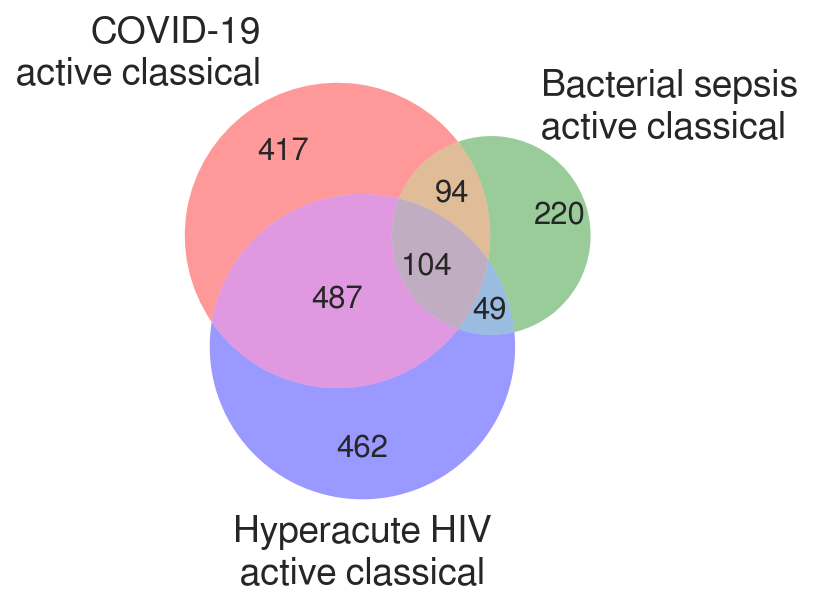

In [62]:
venn3(subsets = [set(a), set(b), set(c)], set_labels = ('COVID-19\nactive classical', 
                                                        'Bacterial sepsis\nactive classical', 
                                                        'Hyperacute HIV\nactive classical'))
plt.savefig(master_dir + 'output/disease_comparisons/gex_high_vs_non-PE/Monocyte/venn-Monocyte.pdf')

In [63]:
diseases = ['COVID', 'Sepsis', 'HIV', 'COVID and sepsis', 'Sepsis and HIV', 'COVID and HIV', 'All']
ai = set(a).difference(set(b)).difference(set(c))
bi = set(b).difference(set(a)).difference(set(c))
ci = set(c).difference(set(b)).difference(set(a))
di = d.difference(g)
ei = e.difference(g)
fi = f.difference(g)

# Save the lists of these genes
for i, gene_list in enumerate([ai, bi, ci, di, ei, fi, g]):
    f = open(master_dir + 'output/disease_comparisons/gex_high_vs_non-PE/Monocyte/' + diseases[i] + '.txt', 'w')
    for j in gene_list:
        f.write(j + '\n')
    f.close()

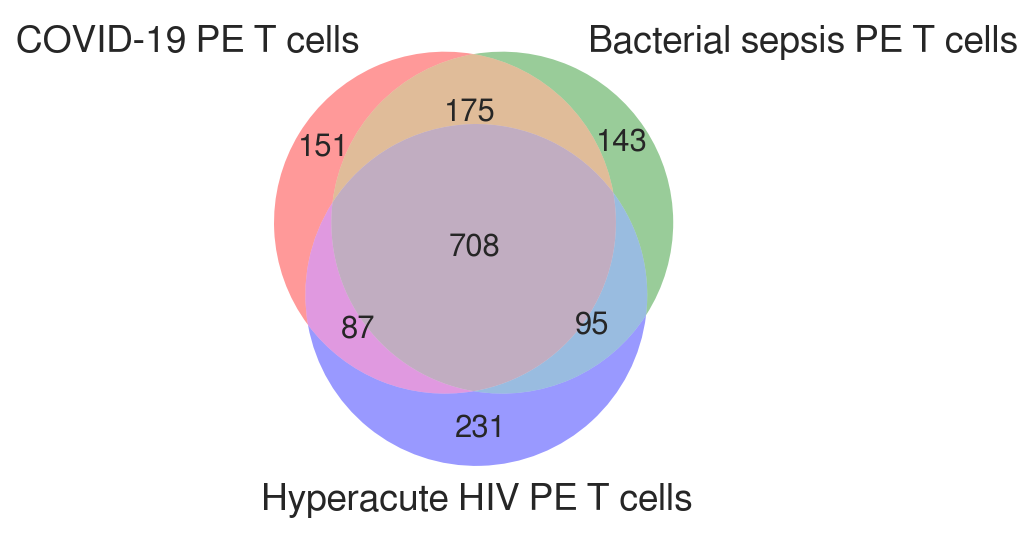

In [246]:
#a = sc.get.rank_genes_groups_df(data_metab, 'PE T-cells of COVID-19', 
#                                pval_cutoff=0.05, key='rank_genes_groups_COVID')['names']
#b = sc.get.rank_genes_groups_df(data_metab, 'PE T-cells of Bacterial Sepsis', 
#                                pval_cutoff=0.05, key='rank_genes_groups_sepsis')['names']
#c = sc.get.rank_genes_groups_df(data_metab, 'PE T-cells of Hyperacute HIV', 
#                                pval_cutoff=0.05, key='rank_genes_groups_HIV')['names']
venn_dict = {'COVID-19 dysfunctional classical': set(a),
            'Bacterial sepsis dysfunctional classical': set(b),
            'Hyperacute HIV dysfunctional classical': set(c),
            'Kidney TIL dysfunctional classical': set(d)}
venn(venn_dict)

#venn3(subsets = [set(a), set(b), set(c)], set_labels = ('COVID-19 PE T cells', 
#                                                        'Bacterial sepsis PE T cells', 
#                                                        'Hyperacute HIV PE T cells'))
#plt.savefig(master_dir + 'output/disease_comparisons/gex_high_vs_non-PE/venn.pdf')

In [244]:
len(fi)

87

### Metabolic pathway-based

In [166]:
df_metab_pathways = df_p.loc[:, [1, 4, 0, 3, 2, 5]]
df_metab_pathways.index = metab_genes.index
df_metab_pathways.columns = pd.Series(['Non PE T-cells of Bacterial Sepsis',
'Non PE T-cells of COVID-19', 'Non PE T-cells of Hyperacute HIV', 'PE T-cells of Bacterial Sepsis',
'PE T-cells of COVID-19', 'PE T-cells of Hyperacute HIV']).iloc[[1, 4, 0, 3, 2, 5]]

adata_metab_pathways = sc.AnnData(df_p.loc[:, [1, 4, 0, 3, 2, 5]].transpose())
adata_metab_pathways.var = pd.DataFrame(metab_genes.index.values).set_index(metab_genes.index.values)
adata_metab_pathways.obs = pd.DataFrame({obs_name : pd.Series(['Non PE T-cells of Bacterial Sepsis',
'Non PE T-cells of COVID-19', 'Non PE T-cells of Hyperacute HIV', 'PE T-cells of Bacterial Sepsis',
'PE T-cells of COVID-19', 'PE T-cells of Hyperacute HIV']).iloc[[1, 4, 0, 3, 2, 5]]})
adata_metab_pathways.obs[obs_name] = adata_metab_pathways.obs[obs_name].astype('category')

/home/jwlee/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([1, 4], dtype='int64'), …


/home/jwlee/.local/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


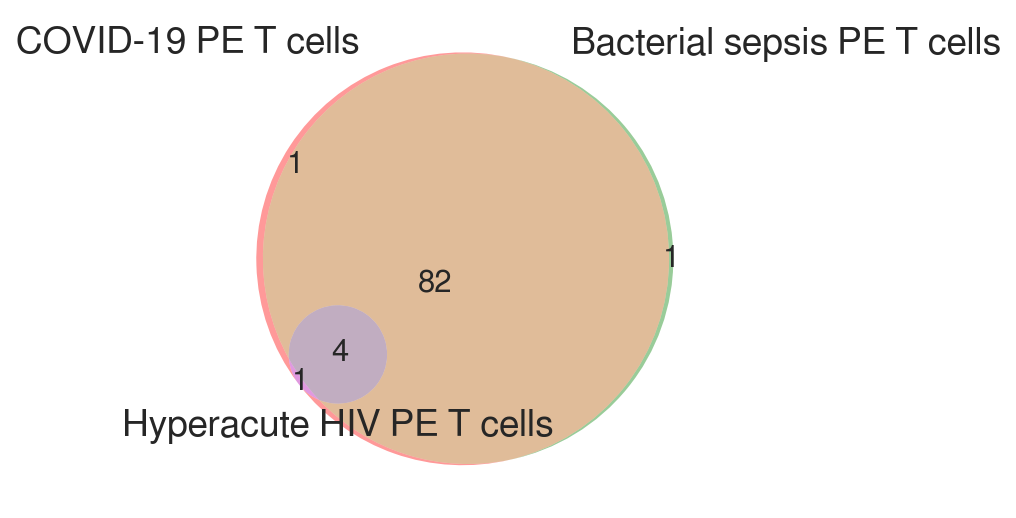

In [167]:
a = df_metab_pathways[df_metab_pathways['PE T-cells of COVID-19'] > 1.0].index.values
b = df_metab_pathways[df_metab_pathways['PE T-cells of Bacterial Sepsis'] > 1.0].index.values
c = df_metab_pathways[df_metab_pathways['PE T-cells of Hyperacute HIV'] > 1.0].index.values

venn3(subsets = [set(a), set(b), set(c)], set_labels = ('COVID-19 PE T cells', 
                                                        'Bacterial sepsis PE T cells', 
                                                        'Hyperacute HIV PE T cells'))

/home/jwlee/.local/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


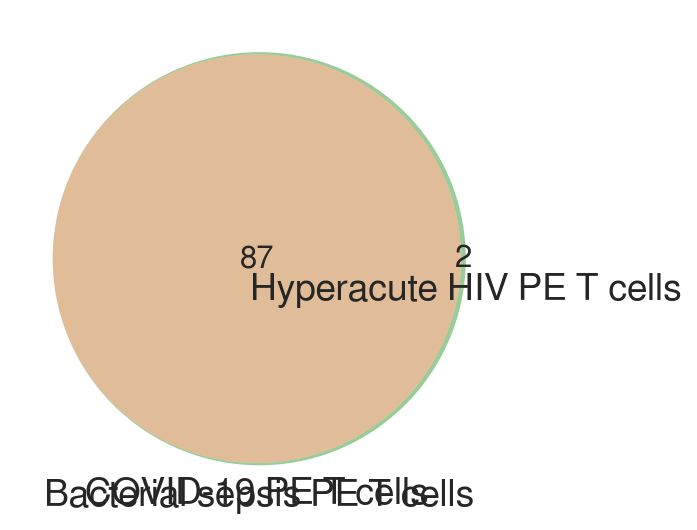

In [168]:
a = df_metab_pathways[df_metab_pathways['PE T-cells of COVID-19'] > df_metab_pathways['Non PE T-cells of COVID-19']].index.values
b = df_metab_pathways[df_metab_pathways['PE T-cells of Bacterial Sepsis'] > df_metab_pathways['Non PE T-cells of Bacterial Sepsis']].index.values
c = df_metab_pathways[df_metab_pathways['PE T-cells of Hyperacute HIV'] > df_metab_pathways['PE T-cells of Hyperacute HIV']].index.values

venn3(subsets = [set(a), set(b), set(c)], set_labels = ('COVID-19 PE T cells', 
                                                        'Bacterial sepsis PE T cells', 
                                                        'Hyperacute HIV PE T cells'))

## Box plot of metabolic pathway activities per cell group

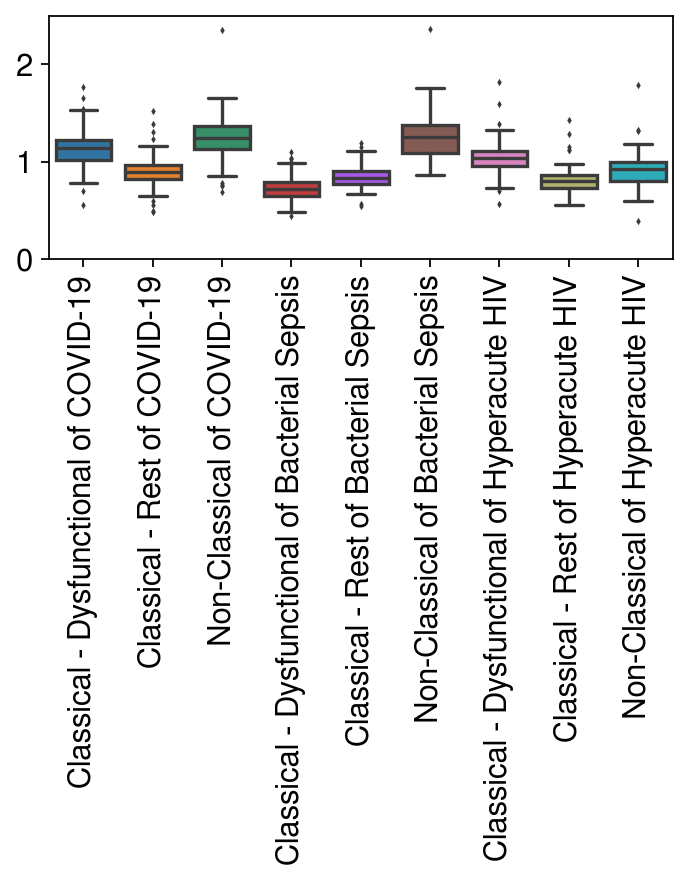

In [88]:
df_metab_pathways = df_p.loc[:, [1, 4, 7, 0, 3, 6, 2, 5, 8]]
df_metab_pathways.index = metab_genes.index
df_metab_pathways.columns = pd.Series(['Classical - Dysfunctional of Bacterial Sepsis',
                        'Classical - Dysfunctional of COVID-19',
                        'Classical - Dysfunctional of Hyperacute HIV',
                        'Classical - Rest of Bacterial Sepsis',
                        'Classical - Rest of COVID-19',
                        'Classical - Rest of Hyperacute HIV',
                        'Non-Classical of Bacterial Sepsis',
                        'Non-Classical of COVID-19',
                        'Non-Classical of Hyperacute HIV']).iloc[[1, 4, 7, 0, 3, 6, 2, 5, 8]]

f = plt.figure(figsize=(5, 2))
f = sns.boxplot(x=np.repeat(df_metab_pathways.columns.values, 90), 
            y=np.array(df_metab_pathways.transpose()).flatten(), fliersize=1)
f.set_xticklabels(labels=df_metab_pathways.columns.values, rotation=90)
f.set_ylim([0, 2.5])
plt.grid(False)
plt.savefig(master_dir + 'output/disease_comparisons/metab-pathways-per-dz-no_cancer-Monocyte.pdf')

In [50]:
temp = df_metab_pathways.columns.copy()
for i in temp:
    temp = temp.drop(i)
    for j in temp:
        print('\n', i, 'vs', j, ':', wilcoxon(df_metab_pathways[i], df_metab_pathways[j]).pvalue)


 1 vs 5 : 2.9802376999144246e-16

 1 vs 9 : 0.0016184546636297899

 1 vs 0 : 8.598823709969929e-16

 1 vs 4 : 4.335520403391141e-13

 1 vs 8 : 0.002886800802486302

 1 vs 2 : 0.00036847189818278963

 1 vs 6 : 7.096494265883984e-14

 1 vs 10 : 6.62566595718181e-09

 1 vs 3 : 7.990440298968495e-15

 1 vs 7 : 2.4594327105733285e-13

 1 vs 11 : 4.297752085493305e-16

 5 vs 9 : 2.9802376999144246e-16

 5 vs 0 : 4.1044042296761745e-08

 5 vs 4 : 0.10107729905456435

 5 vs 8 : 1.2058140943366404e-14

 5 vs 2 : 2.1068947862269298e-08

 5 vs 6 : 0.0008089302085273563

 5 vs 10 : 0.02264212855993621

 5 vs 3 : 1.9287294406628382e-16

 5 vs 7 : 2.9802376999144246e-16

 5 vs 11 : 1.8034059447633587e-16

 9 vs 0 : 2.8686900964572683e-15

 9 vs 4 : 1.2287308966039563e-13

 9 vs 8 : 0.9150843005433441

 9 vs 2 : 1.592658581140227e-08

 9 vs 6 : 3.492556337883216e-14

 9 vs 10 : 2.2482862702296897e-10

 9 vs 3 : 4.337502225218799e-14

 9 vs 7 : 1.0799183697558873e-12

 9 vs 11 : 1.9287294406628382e-1

### Same as above, no cancer

In [ ]:
df_metab_pathways = df_p.loc[:, [1, 4, 7, 0, 3, 6, 2, 5, 8]]
df_metab_pathways.index = metab_genes.index
df_metab_pathways.columns = pd.Series(['Classical - Dysfunctional of Bacterial Sepsis',
                        'Classical - Dysfunctional of COVID-19',
                        'Classical - Dysfunctional of Hyperacute HIV',
                        'Classical - Dysfunctional of Kidney TIL',
                        'Classical - Rest of Bacterial Sepsis',
                        'Classical - Rest of COVID-19',
                        'Classical - Rest of Hyperacute HIV',
                        'Classical - Rest of Kidney TIL',
                        'Non-Classical of Bacterial Sepsis',
                        'Non-Classical of COVID-19',
                        'Non-Classical of Hyperacute HIV',
                        'Non-Classical of Kidney TIL']).iloc[[1, 5, 9, 0, 4, 8, 2, 6, 10, 3, 7, 11]]

f = plt.figure(figsize=(5, 2))
f = sns.boxplot(x=np.repeat(df_metab_pathways.columns.values, 90), 
            y=np.array(df_metab_pathways.transpose()).flatten(), fliersize=1)
f.set_xticklabels(labels=df_metab_pathways.columns.values, rotation=90)
f.set_ylim([0, 2.5])
plt.grid(False)
plt.savefig(master_dir + 'output/disease_comparisons/metab-pathways-per-dz-Monocyte.pdf')